In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda:0"

In [ ]:
train_dir = "/content/drive/MyDrive/melanoma_cancer_dataset/train"
test_dir = "/content/drive/MyDrive/melanoma_cancer_dataset/test"
# Pytorch ImageFolder and DataLoader are way too overpowered.
train_data = torchvision.datasets.ImageFolder(train_dir, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.ImageFolder(test_dir, transform=torchvision.transforms.ToTensor())
len(train_data)
#9605 training images
len(test_data)
#1000 testing images

1000

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
print(train_data[0][0].shape)
# sanity checking, imagefolder changes tensor shape but thats alright I guess.
for x, t in train_loader:
    print(x, t)
    print(x.shape)
    break

torch.Size([3, 300, 300])
tensor([[[[0.6941, 0.6824, 0.6667,  ..., 0.6980, 0.7020, 0.7020],
          [0.6863, 0.6784, 0.6706,  ..., 0.6863, 0.6863, 0.6863],
          [0.6784, 0.6784, 0.6784,  ..., 0.6902, 0.6902, 0.6902],
          ...,
          [0.6784, 0.6745, 0.6784,  ..., 0.5490, 0.5333, 0.5255],
          [0.6745, 0.6745, 0.6784,  ..., 0.5451, 0.5216, 0.5059],
          [0.6706, 0.6706, 0.6745,  ..., 0.5451, 0.5137, 0.4941]],

         [[0.5098, 0.4980, 0.4824,  ..., 0.5216, 0.5255, 0.5255],
          [0.5020, 0.4941, 0.4863,  ..., 0.5098, 0.5098, 0.5098],
          [0.4941, 0.4941, 0.4941,  ..., 0.5137, 0.5137, 0.5137],
          ...,
          [0.5569, 0.5529, 0.5569,  ..., 0.3843, 0.3725, 0.3647],
          [0.5529, 0.5529, 0.5569,  ..., 0.3804, 0.3608, 0.3451],
          [0.5490, 0.5490, 0.5529,  ..., 0.3804, 0.3490, 0.3333]],

         [[0.5412, 0.5216, 0.5059,  ..., 0.4980, 0.5020, 0.5020],
          [0.5333, 0.5176, 0.5098,  ..., 0.4863, 0.4863, 0.4863],
          [0.525

In [ ]:
class MelanomaCNN(nn.Module):
    def __init__(self, width=3):
        """
        Init method for the model.
        """
        super(MelanomaCNN, self).__init__()
        self.width = width
        self.maxpool_layer = nn.MaxPool2d(2,2)
        self.maxpool_layer.cuda()
        # first conv2d layer
        self.conv1 = nn.Conv2d(
            in_channels=self.width,
            out_channels=3,
            kernel_size=3,
        )
        self.conv1.cuda()

        self.temp = nn.Conv2d(
            in_channels=3,
            out_channels=6,
            kernel_size=3
        )
        self.temp.cuda()

        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=12,
            kernel_size=3
        )
        self.conv2.cuda()

        self.conv3 = nn.Conv2d(
            in_channels=12,
            out_channels=12,
            kernel_size=3
        )
        self.conv3.cuda()

        self.conv4 = nn.Conv2d(
            in_channels=12,
            out_channels=24,
            kernel_size=3
        )
        self.conv4.cuda()

        self.conv5 = nn.Conv2d(
            in_channels=24,
            out_channels=36,
            kernel_size=3
        )
        self.conv5.cuda()

        self.fc1 = nn.Linear(144,100)
        self.fc1.cuda()
        self.fc2 = nn.Linear(100,2)
        self.fc2.cuda()

        # final output should be batch size * 2

    def forward(self,x):
        x = torch.nn.functional.normalize(x,p=3)
        x = self.maxpool_layer(torch.relu(self.conv1(x)))
        x.cuda()

        x = self.maxpool_layer(torch.relu(self.temp(x)))
        x.cuda()

        x = self.maxpool_layer(torch.relu(self.conv2(x)))
        x.cuda()

        x = self.maxpool_layer(torch.relu(self.conv3(x)))
        x.cuda()

        x = self.maxpool_layer(torch.relu(self.conv4(x)))
        x.cuda()

        x = self.maxpool_layer(torch.relu(self.conv5(x)))
        x.cuda()
        # flatten the image.
        x = x.view(x.shape[0],-1)
        x.cuda()

        # might swap relu out for smth else
        x = torch.relu(self.fc1(x))
        x.cuda()
        return torch.sigmoid(self.fc2(x))

In [ ]:
def get_accuracy(model, data, device=torch.device("cuda")):
    """
    Accuracy function, self explanatory.
    """
    loader = torch.utils.data.DataLoader(data, batch_size=256)
    model.to(device)
    model.eval() # annotate model for evaluation (important for batch normalization)
    correct = 0
    total = 0
    for imgs, labels in loader:
        labels = labels.to(device)
        output = model(imgs.to(device))
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_model(model,
                train_data,
                valid_data,
                batch_size=64,
                weight_decay=0.0,
                learning_rate=0.001,
                num_epochs=10,
                plot_every=20,
                plot=True,
                device=torch.device("cuda")):
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    model = model.to(device) # move model to GPU if applicable
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    # for plotting
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for epoch in range(num_epochs):
            for imgs, labels in iter(train_loader):
                if imgs.size()[0] < batch_size:
                    continue
                labels = labels.to(device)
                imgs = imgs.to(device)
                model.train()
                out = model(imgs)
                loss = criterion(out, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                iter_count += 1
                if iter_count % plot_every == 0:
                    loss = float(loss)
                    tacc = get_accuracy(model, train_data, device)
                    vacc = get_accuracy(model, valid_data, device)
                    print("Iter %d; Loss %f; Train Acc %.3f; Val Acc %.3f" % (iter_count, loss, tacc, vacc))

                    iters.append(iter_count)
                    train_loss.append(loss)
                    train_acc.append(tacc)
                    val_acc.append(vacc)
    finally:
        plt.figure()
        plt.plot(iters[:len(train_loss)], train_loss)
        plt.title("Loss over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")

        plt.figure()
        plt.plot(iters[:len(train_acc)], train_acc)
        plt.plot(iters[:len(val_acc)], val_acc)
        plt.title("Accuracy over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.legend(["Train", "Validation"])

Iter 20; Loss 0.696771; Train Acc 0.521; Val Acc 0.500
Iter 40; Loss 0.701273; Train Acc 0.521; Val Acc 0.500
Iter 60; Loss 0.682712; Train Acc 0.521; Val Acc 0.500
Iter 80; Loss 0.688606; Train Acc 0.627; Val Acc 0.648
Iter 100; Loss 0.635897; Train Acc 0.649; Val Acc 0.697
Iter 120; Loss 0.611340; Train Acc 0.700; Val Acc 0.732
Iter 140; Loss 0.583330; Train Acc 0.713; Val Acc 0.753
Iter 160; Loss 0.632803; Train Acc 0.707; Val Acc 0.734
Iter 180; Loss 0.528380; Train Acc 0.704; Val Acc 0.761
Iter 200; Loss 0.532108; Train Acc 0.754; Val Acc 0.789
Iter 220; Loss 0.564980; Train Acc 0.730; Val Acc 0.757
Iter 240; Loss 0.506782; Train Acc 0.772; Val Acc 0.805
Iter 260; Loss 0.469351; Train Acc 0.771; Val Acc 0.797
Iter 280; Loss 0.501051; Train Acc 0.785; Val Acc 0.807
Iter 300; Loss 0.519044; Train Acc 0.774; Val Acc 0.807
Iter 320; Loss 0.490240; Train Acc 0.788; Val Acc 0.787
Iter 340; Loss 0.480259; Train Acc 0.783; Val Acc 0.799
Iter 360; Loss 0.562011; Train Acc 0.779; Val Acc 0.

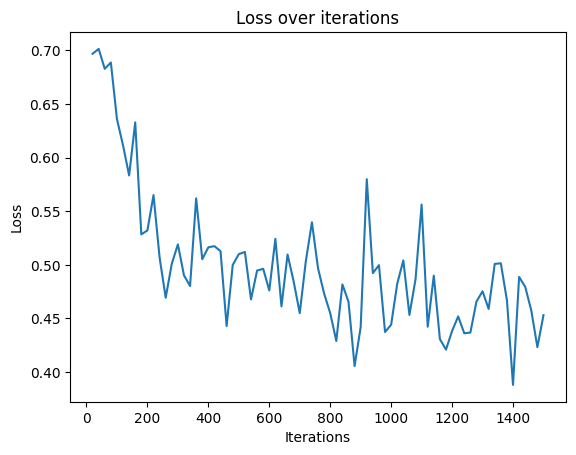

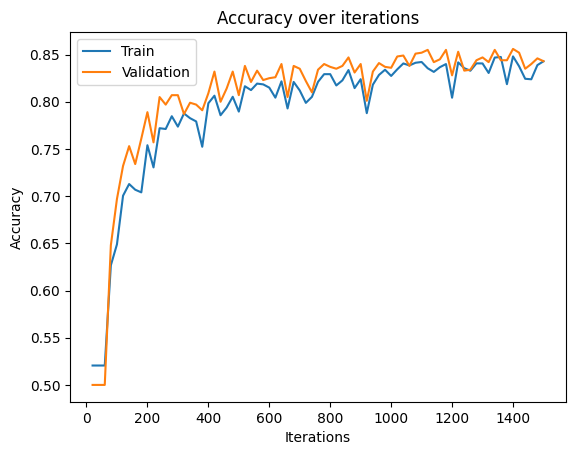

In [ ]:
model = MelanomaCNN()
train_model(model, train_data, test_data)

In [ ]:
model
torch.save(model.state_dict(), "/content/drive/MyDrive/model.pt")